In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, tilt_distance_LI, robust_smooth, normalize_matrix, calc_ow, fit_psi_params, psi_params


#### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = np.squeeze(ssh_dataset['uo'][:].data), np.squeeze(ssh_dataset['vo'][:].data) 
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


#### SADCP Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/ESP_Paper_Data/sadcp_data_CCE_2023.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807,x,y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997.725425,99321.875000
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.695073,95668.330556
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660.396047,91919.202778
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN,5980.012364,88642.647222
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6325.742980,88318.280556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10568.100129,83215.672222
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.775728,86587.708333
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10569.073333,90026.241667
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.370226,93428.288889


(np.float64(-150000.0),
 np.float64(150000.0),
 np.float64(-150000.0),
 np.float64(150000.0))

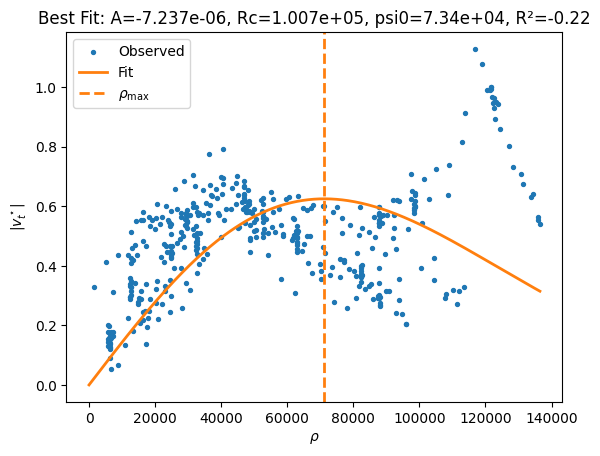

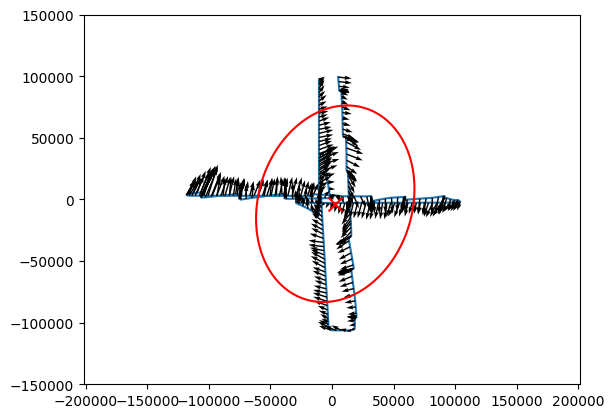

In [4]:
x = np.linspace(-150000, 150000, 101)
y = np.linspace(-150000, 150000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xi, yi, ui, vi = df_sadcp.x,  df_sadcp.y, df_sadcp.u_37, df_sadcp.v_37

xc_0, yc_0, w_0, Q_0, Rc_0, psi0_0, A_0 = espra(xi, yi, ui, vi, plot_flag=True, Rc_max=150000)

plt.figure()
plt.plot(df_sadcp.x, df_sadcp.y)
plt.quiver(xi, yi, ui, vi, zorder=2)
plt.scatter(xc_0, yc_0, marker='x', s=100, color='r', zorder=3)

dx_ell, dy_ell = X - xc_0, Y - yc_0
rho2_ell = Q_0[0,0]*dx_ell**2 + 2*Q_0[1,0]*dx_ell*dy_ell + Q_0[1,1]*dy_ell**2
plt.contour(X, Y, rho2_ell, levels=[Rc_0**2/2],
            colors='r')

plt.axis('equal')


np.float64(72726.75339206953)

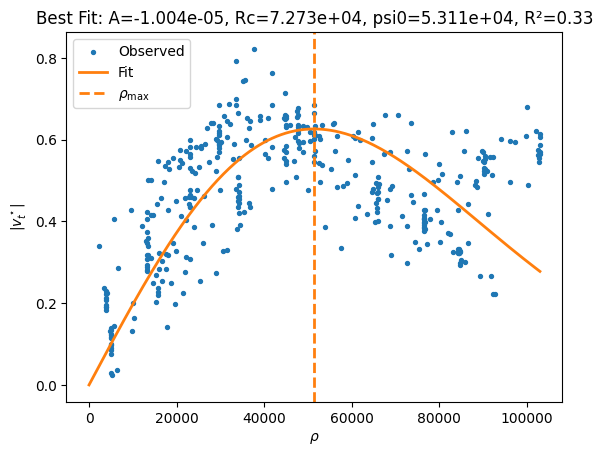

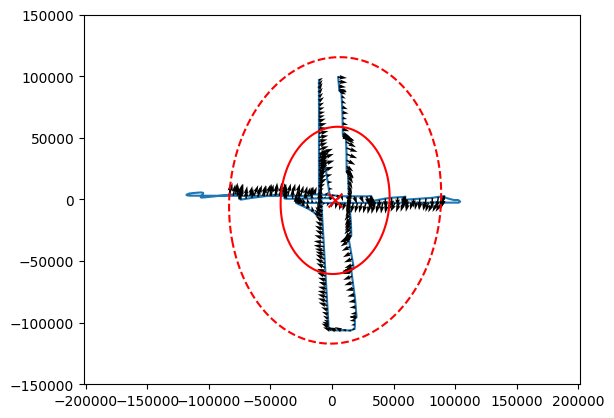

In [5]:
mask_rho = 100000

dx0, dy0 = df_sadcp.x - xc_0,  df_sadcp.y - yc_0
rho2 = Q_0[0,0]*dx0**2 + 2*Q_0[0,1]*dx0*dy0 + Q_0[1,1]*dy0**2
mask = np.sqrt(rho2) < mask_rho

xi, yi, ui, vi = df_sadcp[mask].x,  df_sadcp[mask].y, df_sadcp[mask].u_37, df_sadcp[mask].v_37

xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, plot_flag=True, Rc_max=150000)

plt.figure()
plt.plot(df_sadcp.x, df_sadcp.y)
plt.quiver(xi, yi, ui, vi, zorder=2, scale=30)
plt.scatter(xc, yc, marker='x', s=100, color='r', zorder=3)

dx_ell, dy_ell = X - xc, Y - yc
rho2_ell = Q[0,0]*dx_ell**2 + 2*Q[1,0]*dx_ell*dy_ell + Q[1,1]*dy_ell**2
plt.contour(X, Y, rho2_ell, levels=[Rc**2/2],
            colors='r')
plt.contour(X, Y, rho2_ell, levels=[mask_rho**2],
            colors='r', linestyles='--')

plt.axis('equal')
Rc

,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Depth
0,-451.605262,-849.184148,-0.000038,"[[1.1312061838979988, -0.04918842388725238], [...",70596.642706,53681.932286,-0.000011,0.900779,0.671786,37
1,-438.441250,-813.024330,-0.000038,"[[1.138066313381316, -0.05797818694163663], [-...",71271.872967,53871.172129,-0.000011,0.902483,0.640167,47
2,-130.968639,-357.449572,-0.000037,"[[1.1496814830574626, -0.07651004778684618], [...",72305.687050,54195.803030,-0.000010,0.893556,0.606533,57
3,360.409038,101.498426,-0.000037,"[[1.1514242688583756, -0.08742483546411431], [...",73713.803890,54624.464248,-0.000010,0.895294,0.625438,67
4,770.535459,551.415020,-0.000036,"[[1.1439140353389983, -0.08469922948221359], [...",74411.138858,54234.609643,-0.000010,0.902410,0.655432,77
...,...,...,...,...,...,...,...,...,...,...
62,96.080473,79.444393,-0.000028,"[[1.0443819490599509, -0.0678075345811058], [-...",73245.965181,40576.934887,-0.000008,0.913312,0.644523,657
63,469.308627,267.919755,-0.000027,"[[1.0302431601554138, -0.09480290278919297], [...",73249.188907,40278.420968,-0.000008,0.918875,0.688223,667
64,829.743352,622.265609,-0.000027,"[[1.030617213645552, -0.10762238164522553], [-...",74061.819729,40121.337251,-0.000007,0.917113,0.683137,677
65,-78.841405,1121.415953,-0.000026,"[[1.015005204018253, -0.09352552966929692], [-...",74556.956229,40016.610386,-0.000007,0.918132,0.746006,687


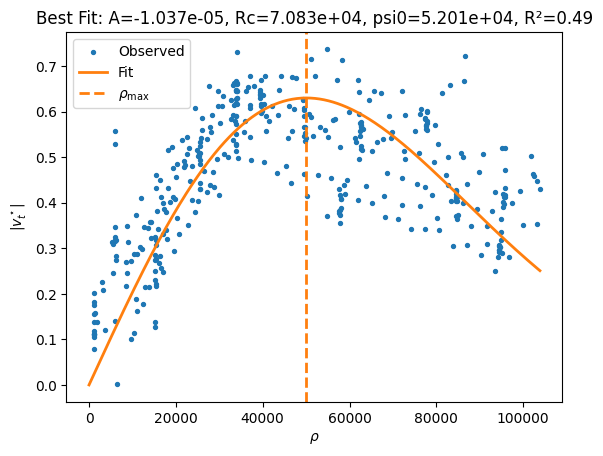

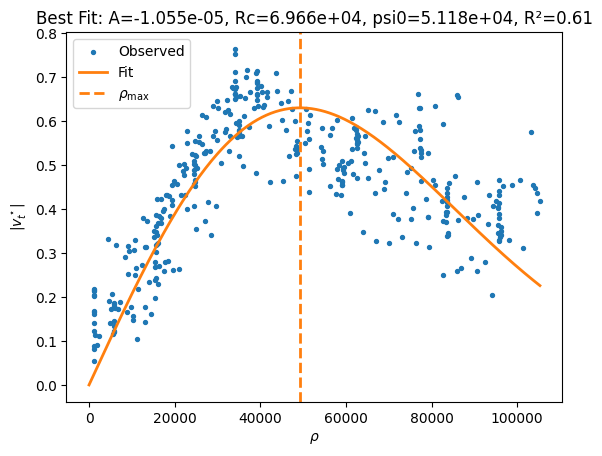

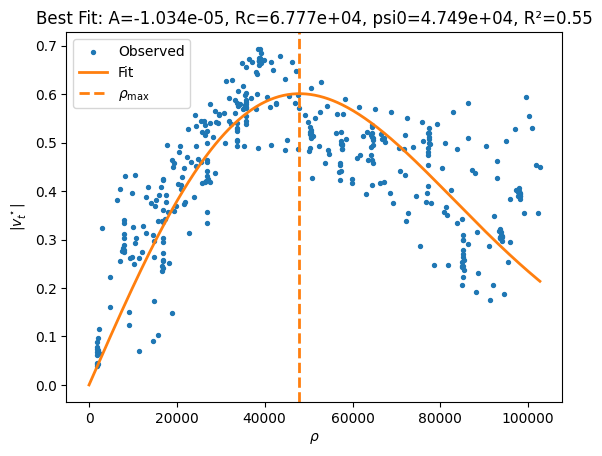

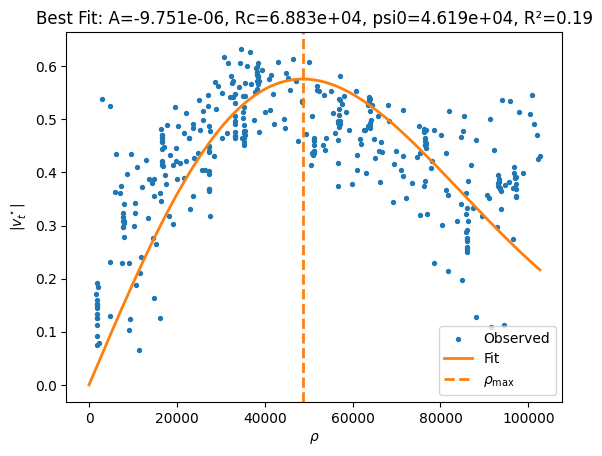

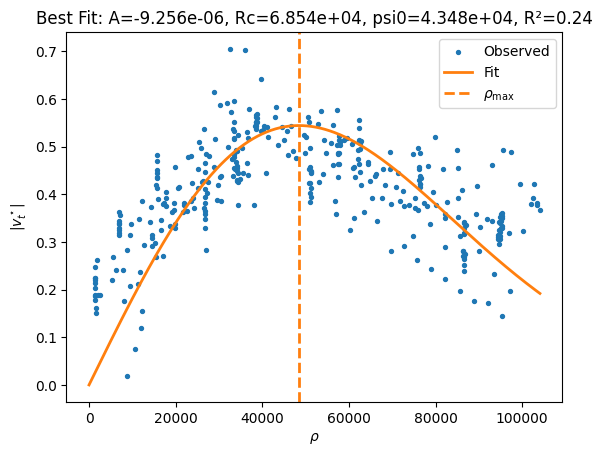

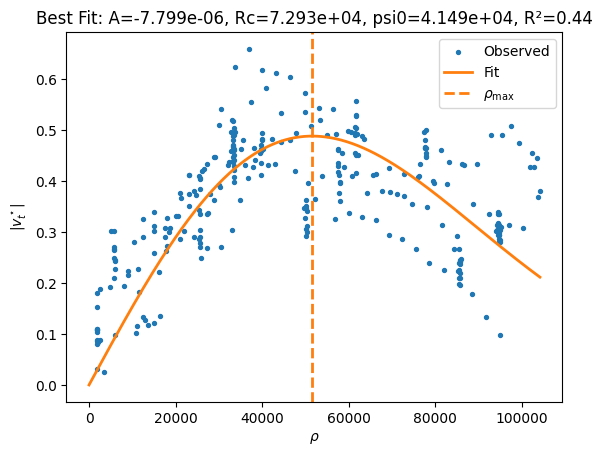

In [6]:
dx0, dy0 = df_sadcp.x - xc_0,  df_sadcp.y - yc_0
rho2 = Q_0[0,0]*dx0**2 + 2*Q_0[0,1]*dx0*dy0 + Q_0[1,1]*dy0**2
core_mask = np.sqrt(rho2) < 40000
outer_core_mask = np.sqrt(rho2) < 100000

df_core_sadcp = df_sadcp[core_mask] 
df_outer_core_sadcp = df_sadcp[outer_core_mask]

u_cols = [col for col in df_core_sadcp.columns if 'u' in col]
v_cols = [col for col in df_core_sadcp.columns if 'v' in col]

df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'r2_1', 'r2_2', 'Depth'])
dic_depth = {}
for k, (u_col, v_col) in enumerate(zip(u_cols, v_cols)):
    xi, yi = df_core_sadcp.x, df_core_sadcp.y
    ui = df_core_sadcp[u_col]
    vi = df_core_sadcp[v_col]
    mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
    xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]

    # All
    axi, ayi = df_outer_core_sadcp.x, df_outer_core_sadcp.y
    aui = df_outer_core_sadcp[u_col]
    avi = df_outer_core_sadcp[v_col]
    mask = ~np.isnan(axi) & ~np.isnan(ayi) & ~np.isnan(aui) & ~np.isnan(avi)
    axi, ayi, aui, avi = axi[mask], ayi[mask], aui[mask], avi[mask]

    depth = int(u_col[2:])
    if (depth < 700) & (len(xi) > 2):
        xc, yc, w, Q, _, _, A0, r2_1, r2_2 = espra(xi, yi, ui, vi, r2_flag=True)
        
        df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        df = df[df.vt <= 0]
        Rc, psi0, A = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=150000, plot=True if k%10==0 else False)     
        
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc,
                                   'psi0': psi0, 'A': A, 'r2_1': r2_1, 'r2_2': r2_2, 'Depth': depth}
        dic_depth[f'Depth{depth}'] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi}
df_res


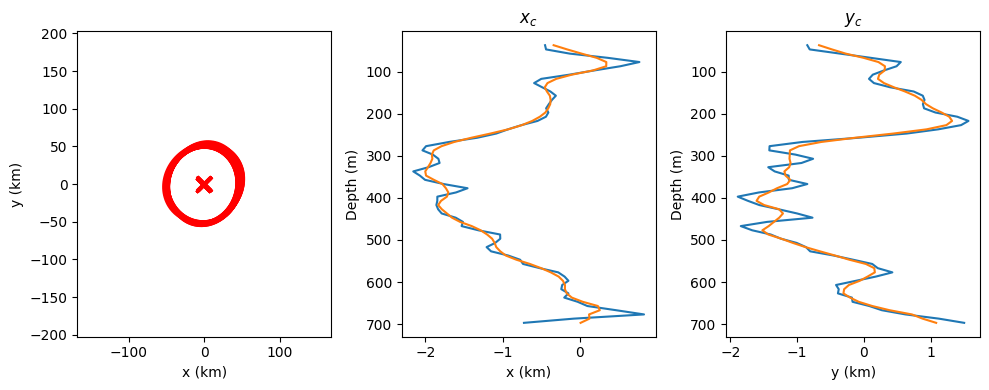

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for k in range(len(df_res)):
    data = df_res.iloc[k]
    axs[0].scatter(data.xc/1e3, data.yc/1e3, marker='x', s=100, color='r', zorder=3)
    dx_ell, dy_ell = X/1e3 - data.xc/1e3, Y/1e3 - data.yc/1e3
    rho2_ell = data.Q[0,0]*dx_ell**2 + 2*data.Q[1,0]*dx_ell*dy_ell + data.Q[1,1]*dy_ell**2
    axs[0].contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.Rc/1e3)**2/2],
                colors='r')
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Depth, window=wdw, num=len(df_res)) 
axs[1].plot(df_res.xc/1e3, df_res.Depth)
axs[1].plot(df_res.sxc/1e3, df_res.Depth)
axs[1].invert_yaxis()
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('Depth (m)'); axs[1].set_title(r'$x_c$')
axs[2].plot(df_res.yc/1e3, df_res.Depth)
axs[2].plot(df_res.syc/1e3, df_res.Depth)
axs[2].invert_yaxis()
axs[2].set_xlabel('y (km)'); axs[2].set_ylabel('Depth (m)'); axs[2].set_title(r'$y_c$')
plt.tight_layout()
                 

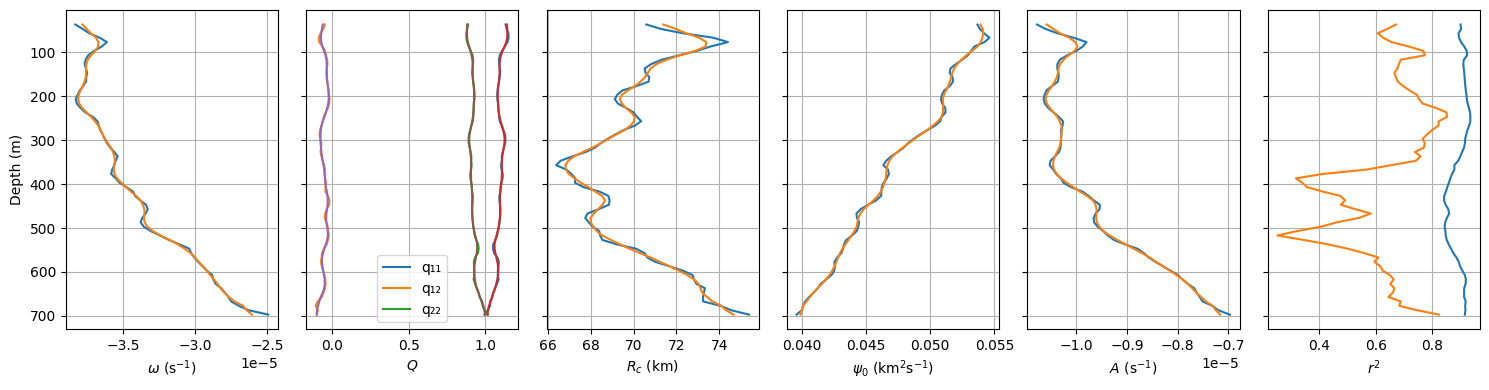

In [8]:
wdw = 5
df_res['sw'] = smooth(df_res.w, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Depth, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 6, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Depth)
axs[0].plot(df_res.sw, df_res.Depth)
axs[0].set_xlabel(r'$\omega$ (s$^{-1}$)')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Depth)
axs[1].plot(df_res.sq12, df_res.Depth)
axs[1].plot(df_res.sq22, df_res.Depth)
axs[1].set_xlabel(r'$Q$')
axs[1].legend()

axs[2].plot(df_res.Rc/1e3, df_res.Depth)
axs[2].plot(df_res.sRc/1e3, df_res.Depth)
axs[2].set_xlabel(r'$R_c$ (km)')

axs[3].plot(df_res.psi0/1e6, df_res.Depth)
axs[3].plot(df_res.spsi0/1e6, df_res.Depth)
axs[3].set_xlabel(r'$\psi_0$ (km$^2$s$^{-1}$)')

axs[4].plot(df_res.A, df_res.Depth)
axs[4].plot(df_res.sA, df_res.Depth)
axs[4].set_xlabel(r'$A$ (s$^{-1}$)')

axs[5].plot(df_res.r2_1, df_res.Depth)
axs[5].plot(df_res.r2_2, df_res.Depth)
axs[5].set_xlabel(r'$r^2$')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()


In [9]:
U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 

    OW[:,:,k] = calc_ow(U[:,:,k].T, V[:,:,k].T, x[1]-x[0], y[1]-y[0])
OW = normalize_matrix(OW)


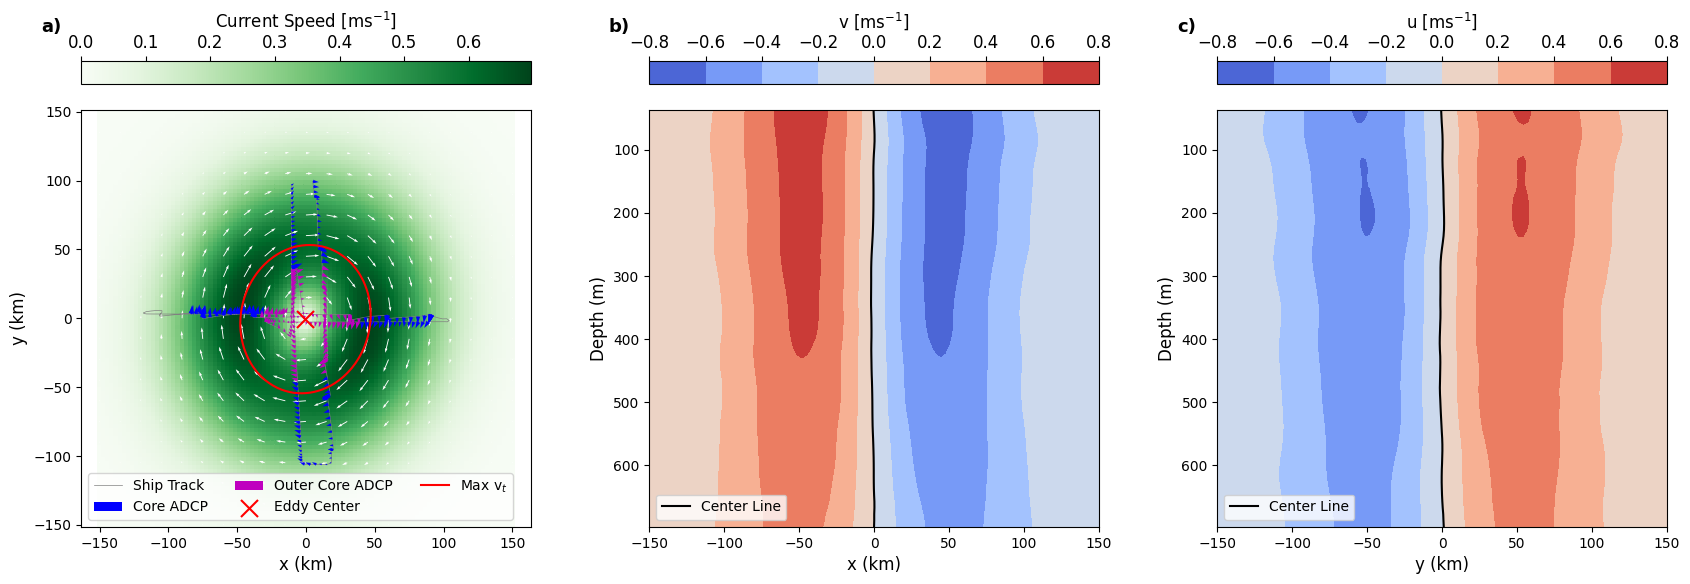

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))
width, scale = .002, 20

# Plot 1
ax = axs[0]
pc = ax.pcolor(X/1e3, Y/1e3, np.hypot(U[:,:,0], V[:,:,0]), zorder=0, cmap='Greens', vmin=0)
cb = fig.colorbar(pc, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'Current Speed [ms$^{-1}$]', fontsize=12)
spac = 5
ax.quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
          U[::spac,::spac,0], V[::spac,::spac,0],
          color='w', width=width, scale=scale, zorder=0)
ax.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, zorder=1, color='grey', lw=.5, label='Ship Track')
# ADCP Data
df = df_outer_core_sadcp.copy()
subset = df_core_sadcp.copy()
df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')
ax.quiver(df_diff.x/1e3, df_diff.y/1e3,
           df_diff.u_37_x, df_diff.v_37_x, color='b', scale=40, zorder=1, label='Core ADCP')
ax.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3,
           df_core_sadcp.u_37, df_core_sadcp.v_37, color='m', scale=40, zorder=1, label='Outer Core ADCP')

data = df_res.iloc[0]
ax.scatter(data.sxc/1e3, data.syc/1e3, marker='x', s=150, color='r', zorder=2, label='Eddy Center')
dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
ax.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=2)
ax.plot([], [], color='r', lw=1.5, label=r'Max v$_t$') 
ax.axis('equal'); ax.set_xlabel('x (km)', fontsize=12);
ax.set_ylabel('y (km)', fontsize=12); ax.legend(loc='lower left', ncol=3)

# Plot 2 and 3
xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

c1 = axs[1].contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
axs[1].plot(df_res.sxc/1e3, df_res.Depth, color='k', label='Center Line')
c2 = axs[2].contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T , cmap='coolwarm')
axs[2].plot(df_res.syc/1e3, df_res.Depth, color='k', label='Center Line')
axs[1].invert_yaxis(); axs[2].invert_yaxis()
axs[1].legend(loc='lower left'); axs[2].legend(loc='lower left')

cb = fig.colorbar(c1, ax=axs[1], location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
cb = fig.colorbar(c2, ax=axs[2], location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)

axs[1].set_ylabel('Depth (m)', fontsize=12); axs[2].set_ylabel('Depth (m)', fontsize=12)
axs[1].set_xlabel('x (km)', fontsize=12); axs[2].set_xlabel('y (km)', fontsize=12)

ax.text(-0.09, 1.22, 'a)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
axs[1].text(-0.09, 1.22, 'b)', transform=axs[1].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
axs[2].text(-0.09, 1.22, 'c)', transform=axs[2].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()


In [11]:
import pickle
df_res_sat = pd.read_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_satellite_ESPRA.pkl")


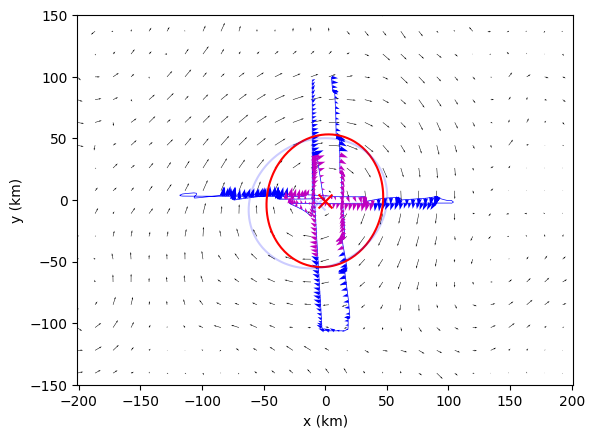

In [12]:
t = df_outer_core_sadcp.Time.mean()

closest = min(tim_ssh, key=lambda tt: abs(tt - t))
utt, vtt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

spac = 2
plt.quiver(x_ssh[::spac,::spac]/1e3, y_ssh[::spac,::spac]/1e3,
           utt[::spac,::spac], vtt[::spac,::spac], width=.001, scale=30)

plt.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, zorder=1, color='b', lw=.5, label='Ship Track')
# plt.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3, df_core_sadcp.u_37, df_core_sadcp.v_37,
#           zorder=1, width=width, scale=40, color='k', label='S-ADCP Data')

df = df_outer_core_sadcp.copy()
subset = df_core_sadcp.copy()
df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')
plt.quiver(df_diff.x/1e3, df_diff.y/1e3,
           df_diff.u_37_x, df_diff.v_37_x, color='b', scale=40, zorder=1)
plt.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3,
           df_core_sadcp.u_37, df_core_sadcp.v_37, color='m', scale=40, zorder=1)

data = df_res.iloc[0]
plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', s=100, color='r')
dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r')

# Sat data
if closest in df_res_sat.Time.values:
    data_sat = df_res_sat[df_res_sat.Time==closest].iloc[0]

    plt.scatter(data_sat.sxc/1e3, data_sat.syc/1e3, marker='x', s=100, color='b', alpha=.2)
    dx_ell, dy_ell = X/1e3 - data_sat.sxc/1e3, Y/1e3 - data_sat.syc/1e3
    rho2_ell = data_sat.sq11*dx_ell**2 + 2*data_sat.sq12*dx_ell*dy_ell + data_sat.sq22*dy_ell**2
    plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data_sat.sRc/1e3)**2/2], colors='b', alpha=.2)

plt.axis('equal'); plt.xlim(X.min()/1e3, X.max()/1e3); plt.ylim(Y.min()/1e3, Y.max()/1e3)
plt.xlabel('x (km)'); plt.ylabel('y (km)');


In [13]:
df_core_sadcp.Time.max() - df_core_sadcp.Time.min()


Timedelta('3 days 21:59:58.999992')

In [14]:
df_outer_core_sadcp.Time.max() - df_outer_core_sadcp.Time.min()


Timedelta('4 days 11:59:59.333336')

In [15]:
df_res['Time_min'] = df_outer_core_sadcp.Time.min()
df_res['Time_max'] = df_outer_core_sadcp.Time.max()
df_res['Time_mean'] = df_outer_core_sadcp.Time.mean()
df_res['Data'] = 'SADCP'
df_res['Method'] = 'ESPRA'
df_res


,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Depth,...,sq12,sq22,sRc,spsi0,sA,Time_min,Time_max,Time_mean,Data,Method
0,-451.605262,-849.184148,-0.000038,"[[1.1312061838979988, -0.04918842388725238], [...",70596.642706,53681.932286,-0.000011,0.900779,0.671786,37,...,-0.061226,0.880895,71391.400908,53916.302482,-0.000011,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
1,-438.441250,-813.024330,-0.000038,"[[1.138066313381316, -0.05797818694163663], [-...",71271.872967,53871.172129,-0.000011,0.902483,0.640167,47,...,-0.067775,0.879453,71972.001653,54093.342923,-0.000010,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
2,-130.968639,-357.449572,-0.000037,"[[1.1496814830574626, -0.07651004778684618], [...",72305.687050,54195.803030,-0.000010,0.893556,0.606533,57,...,-0.071160,0.879655,72459.829094,54121.596267,-0.000010,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
3,360.409038,101.498426,-0.000037,"[[1.1514242688583756, -0.08742483546411431], [...",73713.803890,54624.464248,-0.000010,0.895294,0.625438,67,...,-0.073866,0.880580,73059.806396,54075.549892,-0.000010,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
4,770.535459,551.415020,-0.000036,"[[1.1439140353389983, -0.08469922948221359], [...",74411.138858,54234.609643,-0.000010,0.902410,0.655432,77,...,-0.071745,0.885049,73395.826616,53941.778338,-0.000010,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,96.080473,79.444393,-0.000028,"[[1.0443819490599509, -0.0678075345811058], [-...",73245.965181,40576.934887,-0.000008,0.913312,0.644523,657,...,-0.075031,0.964323,73435.899601,40635.707258,-0.000008,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
63,469.308627,267.919755,-0.000027,"[[1.0302431601554138, -0.09480290278919297], [...",73249.188907,40278.420968,-0.000008,0.918875,0.688223,667,...,-0.084253,0.974347,73680.153615,40388.095013,-0.000007,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
64,829.743352,622.265609,-0.000027,"[[1.030617213645552, -0.10762238164522553], [-...",74061.819729,40121.337251,-0.000007,0.917113,0.683137,677,...,-0.092945,0.986626,74101.565545,40120.390423,-0.000007,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
65,-78.841405,1121.415953,-0.000026,"[[1.015005204018253, -0.09352552966929692], [-...",74556.956229,40016.610386,-0.000007,0.918132,0.746006,687,...,-0.099230,0.992806,74315.465636,40006.254307,-0.000007,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA


In [16]:
df_res.to_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_sadcp_ESPRA.pkl")


In [17]:
df_valid = pd.DataFrame(columns=['Lon', 'Lat', 'Depth']) # Find ADCP data

df_u = df_outer_core_sadcp[[col for col in df_outer_core_sadcp.columns if 'u' in col]]
df_truth = ~np.isnan(df_u)

for k in range(len(df_outer_core_sadcp)):
    xx, yy = df_outer_core_sadcp.iloc[k].x, df_outer_core_sadcp.iloc[k].y
    row = df_truth.iloc[k]

    depths = [int(num[2:]) for num in list(row.index)]
    valid_depth = np.array(depths)[row]
    xs, ys = [xx] * len(valid_depth), [yy] * len(valid_depth), 

    df = pd.DataFrame({'x': xs, 'y': ys, 'Depth': valid_depth})

    if k==0:
        df_valid = df
    else:
        if len(df):
            df_valid = pd.concat([df_valid, df], ignore_index=True)
df_valid.head()


,x,y,Depth
0,4997.725425,99321.875,37
1,4997.725425,99321.875,47
2,4997.725425,99321.875,57
3,4997.725425,99321.875,67
4,4997.725425,99321.875,77


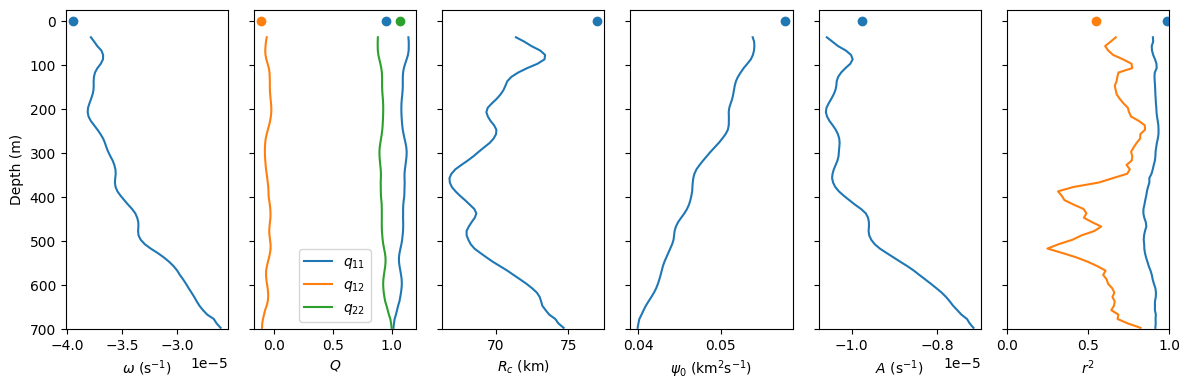

In [18]:
fig, axs = plt.subplots(1, 6, figsize=(12, 4), sharey=True)

t = df_outer_core_sadcp.Time.mean()
closest = min(tim_ssh, key=lambda tt: abs(tt - t))
if closest in df_res_sat.Time.values:
    data_sat = df_res_sat[df_res_sat.Time==closest].iloc[0]
depth = 0

axs[0].scatter(data_sat.sw, depth)
axs[0].plot(df_res.sw, df_res.Depth)
axs[0].set_xlabel(r'$\omega$ (s$^{-1}$)')

axs[1].scatter(data_sat.sq11, depth)
axs[1].scatter(data_sat.sq12, depth)
axs[1].scatter(data_sat.sq22, depth)
axs[1].plot(df_res.sq11, df_res.Depth, label=r'$q_{11}$')
axs[1].plot(df_res.sq12, df_res.Depth, label=r'$q_{12}$')
axs[1].plot(df_res.sq22, df_res.Depth, label=r'$q_{22}$')
axs[1].set_xlabel(r'$Q$')
axs[1].legend()

axs[2].scatter(data_sat.sRc/1e3, depth)
axs[2].plot(df_res.sRc/1e3, df_res.Depth)
axs[2].set_xlabel(r'$R_c$ (km)')

axs[3].scatter(data_sat.spsi0/1e6, depth)
axs[3].plot(df_res.spsi0/1e6, df_res.Depth)
axs[3].set_xlabel(r'$\psi_0$ (km$^2$s$^{-1}$)')

axs[4].scatter(data_sat.sA, depth)
axs[4].plot(df_res.sA, df_res.Depth)
axs[4].set_xlabel(r'$A$ (s$^{-1}$)')

axs[5].scatter(data_sat.r2_1, depth)
axs[5].scatter(data_sat.r2_2, depth)
axs[5].plot(df_res.r2_1, df_res.Depth, label='Core')
axs[5].plot(df_res.r2_2, df_res.Depth, label='Out. Core')
axs[5].set_xlabel(r'$r^2$')
axs[5].set_xlim(0, 1)
# axs[5].legend()

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylim(700, -25)
axs[0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


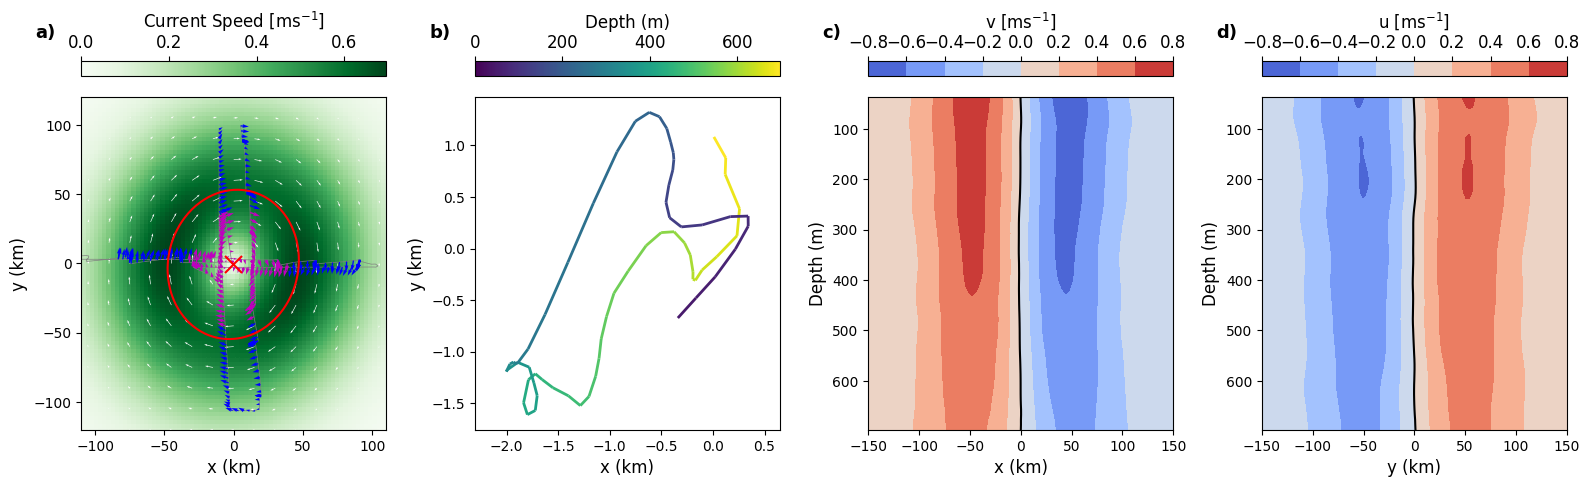

In [19]:
from matplotlib.collections import LineCollection

fig, axs = plt.subplots(1, 4, figsize=(16, 5))
width, scale = .002, 20

# --- (0): Surface currents, ADCP, and eddy ellipse ---
ax = axs[0]
pc = ax.pcolor(X/1e3, Y/1e3, np.hypot(U[:,:,0], V[:,:,0]), zorder=0, cmap='Greens', vmin=0)
cb = fig.colorbar(pc, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'Current Speed [ms$^{-1}$]', fontsize=12)
spac = 5
ax.quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
          U[::spac,::spac,0], V[::spac,::spac,0],
          color='w', width=width, scale=scale, zorder=0)
ax.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, zorder=1, color='grey', lw=.5, label='Ship Track')

# ADCP Data
df = df_outer_core_sadcp.copy()
subset = df_core_sadcp.copy()
df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')
ax.quiver(df_diff.x/1e3, df_diff.y/1e3,
           df_diff.u_37_x, df_diff.v_37_x, color='b', scale=scale, zorder=1, label='Core ADCP')
ax.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3,
           df_core_sadcp.u_37, df_core_sadcp.v_37, color='m', scale=scale, zorder=1, label='Out. Core ADCP')

data = df_res.iloc[0]
ax.scatter(data.sxc/1e3, data.syc/1e3, marker='x', s=150, color='r', zorder=2, label='Eddy Center')
dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
ax.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=2)
ax.plot([], [], color='r', lw=1.5, label=r'Max v$_t$')
ax.axis('equal'); ax.set_xlim(-105, 105); ax.set_ylim(-105, 105)
ax.set_xlabel('x (km)', fontsize=12)
ax.set_ylabel('y (km)', fontsize=12)
# ax.legend(loc='upper left', ncol=3)
ax.text(-0.15, 1.22, 'a)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- (1): Depth-coloured eddy track ---
ax = axs[1]
df = df_res.copy().iloc[::-1]
points = np.array([df.sxc, df.syc]).T.reshape(-1, 1, 2)/1e3
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, df.Depth.max()))
lc.set_array(df.Depth)
lc.set_linewidth(2)
ax.add_collection(lc)
ax.autoscale()
ax.axis('equal')
cb = fig.colorbar(lc, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label='Depth (m)', fontsize=12)
ax.set_xlabel('x (km)', fontsize=12)
ax.set_ylabel('y (km)', fontsize=12)
ax.text(-0.15, 1.22, 'b)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- (2): Meridional section (v) ---
xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

ax = axs[2]
c1 = ax.contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
ax.plot(df_res.sxc/1e3, df_res.Depth, color='k', label='Center Line')
ax.invert_yaxis()
# ax.legend(loc='lower left')
cb = fig.colorbar(c1, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
ax.set_xlabel('x (km)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.text(-0.15, 1.22, 'c)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- (3): Zonal section (u) ---
ax = axs[3]
c2 = ax.contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T, cmap='coolwarm')
ax.plot(df_res.syc/1e3, df_res.Depth, color='k', label='Center Line')
ax.invert_yaxis()
# ax.legend(loc='lower left')
cb = fig.colorbar(c2, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)
ax.set_xlabel('y (km)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.text(-0.15, 1.22, 'd)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()


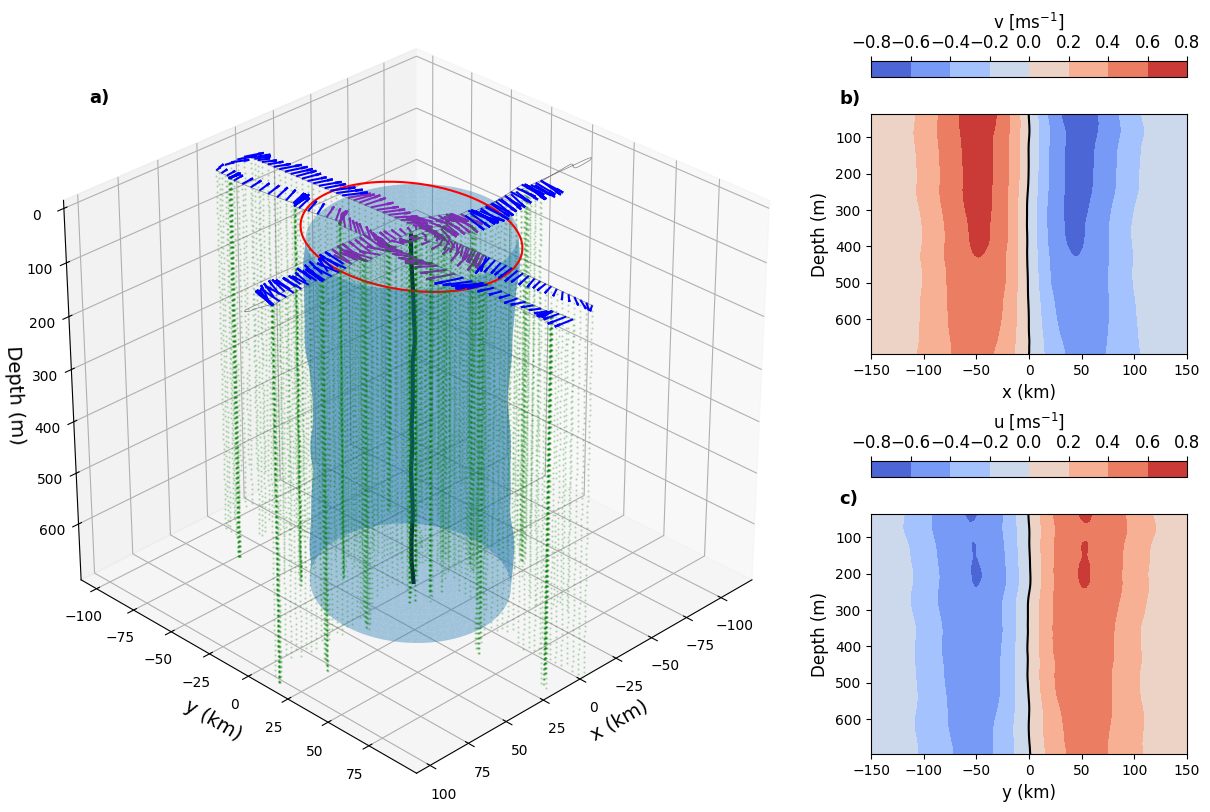

In [20]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import matplotlib.gridspec as gridspec

z = df_res.Depth.values
dz = z[1] - z[0]
dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3

verts, faces, normals, values = measure.marching_cubes(OW, level=-0.2, spacing=(dx, dy, dz))
verts[:,0] += X.min()/1e3
verts[:,1] += Y.min()/1e3
verts[:,2] += z.min()

fig = plt.figure(figsize=(12,8), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 1], wspace=0.0)

# --- 3D PLOT (left side) ---
ax3d = fig.add_subplot(gs[:, :2], projection='3d')

ax3d.scatter(df_valid.x/1e3, df_valid.y/1e3, df_valid.Depth, marker='.', s=2, color='g', alpha=.2, depthshade=False, zorder=0)
ax3d.scatter(np.nan, np.nan, np.nan, s=100, color='g', alpha=1, depthshade=False, label='ADCP Data')

mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
mesh.set_zsort('min')
ax3d.add_collection3d(mesh)

ax3d.set_xlim(df_sadcp.x.min()/1e3, df_sadcp.x.max()/1e3)
ax3d.set_ylim(df_sadcp.y.min()/1e3, df_sadcp.y.max()/1e3)
ax3d.set_zlim(0, z.max())

ax3d.plot(df_res.sxc/1e3, df_res.syc/1e3, df_res.Depth, color='k', lw=3, label='Center Line')
ax3d.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, [37]*len(df_sadcp), lw=.5, color='grey')

df = df_outer_core_sadcp.copy()
subset = df_core_sadcp.copy()
df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')

ax3d.quiver(df_diff.x/1e3, df_diff.y/1e3, [37]*len(df_diff),
            df_diff.u_37_x, df_diff.v_37_x, [0]*len(df_diff), color='b', length=20, label='Surface Core ADCP Data')
ax3d.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3, [37]*len(df_core_sadcp),
            df_core_sadcp.u_37, df_core_sadcp.v_37, [0]*len(df_core_sadcp), color='m', length=20, label='Surface Outer Core ADCP Data')

surf_data = df_res.iloc[0]
dx_ell, dy_ell = X/1e3 - surf_data.sxc/1e3, Y/1e3 - surf_data.syc/1e3
rho2_ell = surf_data.sq11*dx_ell**2 + 2*surf_data.sq12*dx_ell*dy_ell + surf_data.sq22*dy_ell**2
ax3d.contour(X/1e3, Y/1e3, rho2_ell, levels=[(surf_data.sRc/1e3)**2/2], colors='r', zdir='z', offset=37)
ax3d.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')

ax3d.invert_zaxis()
ax3d.set_box_aspect((.1, .1, .09))
ax3d.view_init(elev=30, azim=45)
ax3d.set_xlabel('x (km)', fontsize=14)
ax3d.set_ylabel('y (km)', fontsize=14)
ax3d.set_zlabel('Depth (m)', fontsize=14)
ax3d.text2D(.1, .9, 'a)', transform=ax3d.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- 2x1 SUBPLOTS (right side) ---
gs_right = gs[:, 2].subgridspec(2, 1, hspace=0.0)
ax_v = fig.add_subplot(gs_right[0, 0])
ax_u = fig.add_subplot(gs_right[1, 0])

xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

# Meridional (v)
c1 = ax_v.contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
ax_v.plot(df_res.sxc/1e3, df_res.Depth, color='k')
ax_v.invert_yaxis()
cb = fig.colorbar(c1, ax=ax_v, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
# ax_v.set_title('Zonal Slice', fontsize=12)
ax_v.set_xlabel('x (km)', fontsize=12)
ax_v.set_ylabel('Depth (m)', fontsize=12)
ax_v.text(-0.1, 1.1, 'b)', transform=ax_v.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# Zonal (u)
c2 = ax_u.contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T, cmap='coolwarm')
ax_u.plot(df_res.syc/1e3, df_res.Depth, color='k')
ax_u.invert_yaxis()
cb = fig.colorbar(c2, ax=ax_u, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)
# cb.set_label(label=r'[ms$^{-1}$]', fontsize=12)
# ax_u.set_title('Meridional Slice', fontsize=12)
ax_u.set_xlabel('y (km)', fontsize=12)
ax_u.set_ylabel('Depth (m)', fontsize=12)
ax_u.text(-0.1, 1.1, 'c)', transform=ax_u.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.show()


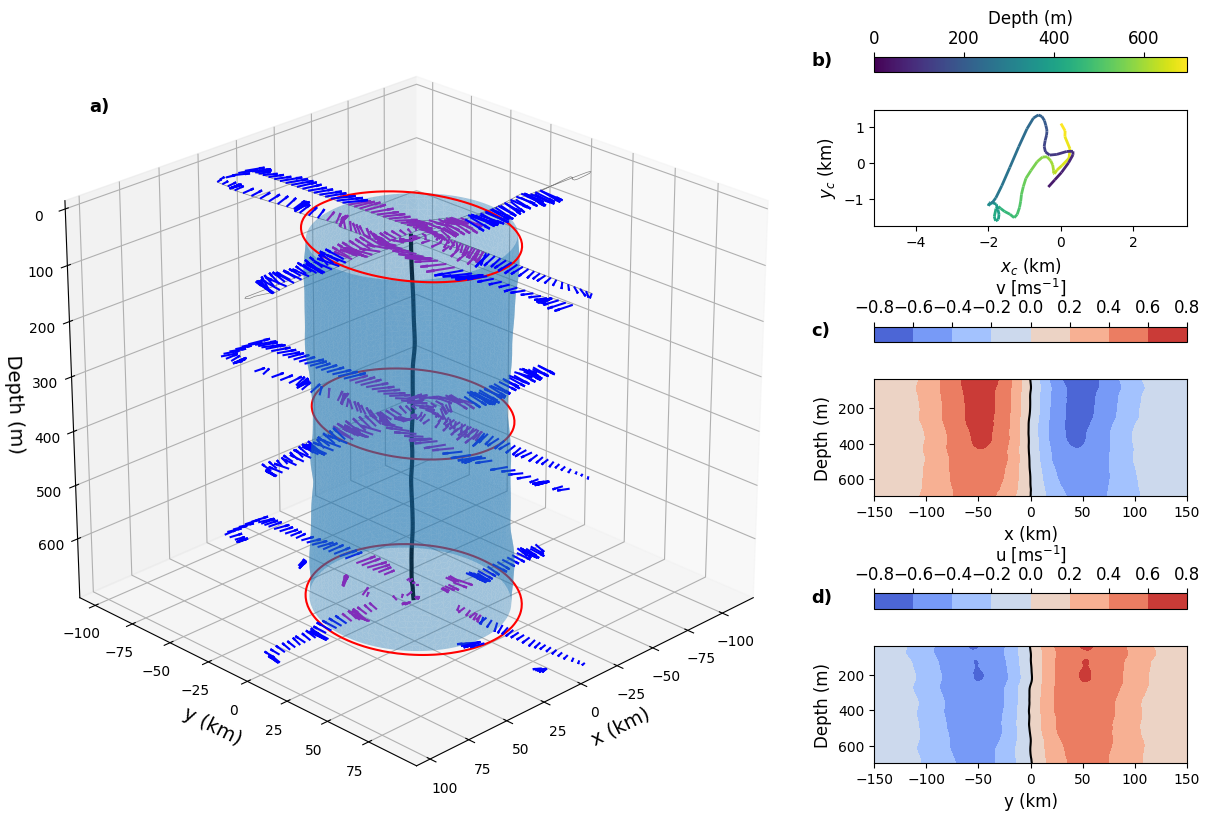

In [21]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

z = df_res.Depth.values
dz = z[1] - z[0]
dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3

verts, faces, normals, values = measure.marching_cubes(OW, level=-0.2, spacing=(dx, dy, dz))
verts[:,0] += X.min()/1e3
verts[:,1] += Y.min()/1e3
verts[:,2] += z.min()

fig = plt.figure(figsize=(12,8), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 1], wspace=0.0)

# --- 3D PLOT (left side) ---
ax3d = fig.add_subplot(gs[:, :2], projection='3d')

# ax3d.scatter(df_valid.x/1e3, df_valid.y/1e3, df_valid.Depth, marker='.', s=2, color='g', alpha=.1, depthshade=False, zorder=0)
# ax3d.scatter(np.nan, np.nan, np.nan, s=100, color='g', alpha=1, depthshade=False, label='ADCP Data')

mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
mesh.set_zsort('min')
ax3d.add_collection3d(mesh)

ax3d.set_xlim(df_sadcp.x.min()/1e3, df_sadcp.x.max()/1e3)
ax3d.set_ylim(df_sadcp.y.min()/1e3, df_sadcp.y.max()/1e3)
ax3d.set_zlim(0, z.max())

ax3d.plot(df_res.sxc/1e3, df_res.syc/1e3, df_res.Depth, color='k', lw=3, label='Center Line')
ax3d.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, [37]*len(df_sadcp), lw=.5, color='grey')

df = df_outer_core_sadcp.copy()
subset = df_core_sadcp.copy()
df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')

for depth in [37, 357, 697]:
    # --- Quiver: Difference velocities ---
    ax3d.quiver(df_diff.x/1e3, df_diff.y/1e3, [depth]*len(df_diff),
                df_diff[f'u_{depth}_x'], df_diff[f'v_{depth}_x'], [0]*len(df_diff),
                color='b', length=20, label='Surface Core ADCP Data')
    # --- Quiver: Core SADCP velocities ---
    ax3d.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3, [depth]*len(df_core_sadcp),
                df_core_sadcp[f'u_{depth}'], df_core_sadcp[f'v_{depth}'], [0]*len(df_core_sadcp),
                color='m', length=20, label='Surface Outer Core ADCP Data')
    # --- Ellipse contour at this depth ---
    surf_data = df_res[df_res.Depth == depth].iloc[0]
    dx_ell = X/1e3 - surf_data.sxc/1e3
    dy_ell = Y/1e3 - surf_data.syc/1e3
    rho2_ell = surf_data.sq11*dx_ell**2 + 2*surf_data.sq12*dx_ell*dy_ell + surf_data.sq22*dy_ell**2
    ax3d.contour(X/1e3, Y/1e3, rho2_ell, levels=[(surf_data.sRc/1e3)**2/2],
                 colors='r', zdir='z', offset=depth)
# Add a legend entry for the contour
ax3d.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')

ax3d.invert_zaxis()
ax3d.set_box_aspect((.1, .1, .09))
ax3d.view_init(elev=25, azim=45)
ax3d.set_xlabel('x (km)', fontsize=14)
ax3d.set_ylabel('y (km)', fontsize=14)
ax3d.set_zlabel('Depth (m)', fontsize=14)
ax3d.text2D(.1, .9, 'a)', transform=ax3d.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- RIGHT SIDE (3×1 STACKED PLOTS) ---
gs_right = gs[:, 2].subgridspec(3, 1, hspace=0)
ax_xy = fig.add_subplot(gs_right[0, 0])
ax_v  = fig.add_subplot(gs_right[1, 0])
ax_u  = fig.add_subplot(gs_right[2, 0])

# (1) XY Depth Track (LineCollection)
df = df_res.copy().iloc[::-1]
points = np.array([df.sxc, df.syc]).T.reshape(-1, 1, 2)/1e3
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, df.Depth.max()))
lc.set_array(df.Depth)
lc.set_linewidth(2)
ax_xy.add_collection(lc)
ax_xy.autoscale()
ax_xy.axis('equal')
cb = fig.colorbar(lc, ax=ax_xy, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label='Depth (m)', fontsize=12)
ax_xy.set_xlabel(r'$x_c$ (km)', fontsize=12)
ax_xy.set_ylabel(r'$y_c$ (km)', fontsize=12)
ax_xy.text(-0.2, 1.5, 'b)', transform=ax_xy.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# (2) Meridional (v)
xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

c1 = ax_v.contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
ax_v.plot(df_res.sxc/1e3, df_res.Depth, color='k')
ax_v.invert_yaxis()
cb = fig.colorbar(c1, ax=ax_v, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
ax_v.set_xlabel('x (km)', fontsize=12)
ax_v.set_ylabel('Depth (m)', fontsize=12)
ax_v.text(-0.2, 1.5, 'c)', transform=ax_v.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# (3) Zonal (u)
c2 = ax_u.contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T, cmap='coolwarm')
ax_u.plot(df_res.syc/1e3, df_res.Depth, color='k')
ax_u.invert_yaxis()
cb = fig.colorbar(c2, ax=ax_u, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)
ax_u.set_xlabel('y (km)', fontsize=12)
ax_u.set_ylabel('Depth (m)', fontsize=12)
ax_u.text(-0.2, 1.5, 'd)', transform=ax_u.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.show()


In [22]:
df_diff

,Time_x,Lon_x,Lat_x,u_27_x,u_37_x,u_47_x,u_57_x,u_67_x,u_77_x,u_87_x,...,v_717_y,v_727_y,v_737_y,v_747_y,v_757_y,v_767_y,v_777_y,v_787_y,v_797_y,v_807_y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
